In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
import copy
import json

In [4]:
# directName = "./"
directName = "./data_1"
script_dict = {}   ### record of each figure and each room of it
room_dict = {}     ### labels for different room: living room, bedroom, ...
for file in os.listdir(directName):
    if file.endswith(".xml"):
        fileNamePre = file[:-4]
        tree = ET.parse(os.path.join(directName, file))
        root = tree.getroot()
        script_dict[fileNamePre] = {}
        script_dict[fileNamePre]['img_name'] = fileNamePre+'.png'
        script_dict[fileNamePre]['points'] = []
        for item in root.findall('object'):
            rooms = [None]*5
            for child in item:
                if(child.tag == 'name'):
                    room_type = child.text
                    room_type_digit = -1
                    if(room_type in room_dict):
                        room_type_digit = room_dict[room_type]
                    else:
                        room_type_digit = len(room_dict)
                        room_dict[room_type] = room_type_digit 
                    rooms[4] = room_type_digit
                elif(child.tag == 'bndbox'):
                    for grandchild in child:
                        if grandchild.tag=='xmin':
                            rooms[0] = int(grandchild.text)
                        elif grandchild.tag=='xmax':
                            rooms[2] = int(grandchild.text)
                        elif grandchild.tag=='ymin':
                            rooms[1] = int(grandchild.text)
                        elif grandchild.tag=='ymax':
                            rooms[3] = int(grandchild.text)
            script_dict[fileNamePre]['points'].append(rooms)

In [3]:
script_dict

{'0134b1-1': {'img_name': '0134b1-1.png',
  'points': [[975, 1200, 823, 955, 0],
   [721, 946, 824, 1092, 1],
   [719, 1102, 1118, 1579, 2],
   [1562, 1875, 968, 1302, 2],
   [1134, 1532, 1107, 1575, 3],
   [1236, 1538, 819, 1105, 4],
   [1559, 1879, 737, 940, 5]]},
 '0134b11-1': {'img_name': '0134b11-1.png',
  'points': [[701, 1057, 682, 846, 1],
   [699, 1066, 875, 1091, 6],
   [702, 1055, 1123, 1543, 2],
   [1083, 1828, 1123, 1550, 3],
   [1084, 1441, 681, 1093, 4],
   [1477, 1830, 805, 1089, 5]]},
 '0134b11-2': {'img_name': '0134b11-2.png',
  'points': [[742, 1093, 683, 840, 1],
   [741, 1100, 873, 1102, 6],
   [736, 1092, 1118, 1546, 2],
   [1126, 1479, 1113, 1543, 2],
   [1524, 1865, 1116, 1545, 2],
   [1126, 1483, 683, 1087, 3],
   [1513, 1866, 811, 1093, 3]]},
 '0134b12-1': {'img_name': '0134b12-1.png',
  'points': [[855, 1082, 768, 958, 0],
   [1413, 1593, 672, 950, 1],
   [1292, 1719, 987, 1197, 6],
   [1304, 1662, 1219, 1655, 2],
   [854, 1275, 985, 1654, 3],
   [1111, 1401,

In [53]:
rescale = 512
script_dict_rescale = {}
for fileName in script_dict.keys():
    filePath = os.path.join(directName, script_dict[fileName]['img_name'])
    script_dict_rescale[fileName] = {}
    script_dict_rescale[fileName]['img_name'] = fileName+f'_{rescale}.png'
    script_dict_rescale[fileName]['points'] = []
    img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    labels = script_dict[fileName]['points']
    x_min = img.shape[0]
    x_max = 0
    y_min = img.shape[1]
    y_max = 0
    for room in labels:
        rx_max = max(room[0],room[2])
        rx_min = min(room[0],room[2])
        ry_max = max(room[1],room[3])
        ry_min = min(room[1],room[3])
        if(rx_max>x_max):
            x_max = rx_max
        if(ry_max>y_max):
            y_max = ry_max
        if(rx_min<x_min):
            x_min = rx_min
        if(ry_min<y_min):
            y_min = ry_min
    x_offset = int((x_max-x_min)*0.1)
    y_offset = int((y_max-y_min)*0.1)
    left_bound_new = max(x_min-x_offset,0)
    right_bound_new = min(x_max+x_offset,img.shape[1])

    down_bound_new = max(y_min-y_offset,0)
    up_bound_new = min(y_max+y_offset,img.shape[0])
    img_level_2 = cv2.resize(img[down_bound_new:up_bound_new, left_bound_new:right_bound_new], (rescale,rescale), interpolation=cv2.INTER_CUBIC)
    
    scale_x = (right_bound_new - left_bound_new)/rescale
    scale_y = (up_bound_new - down_bound_new)/rescale
    
#     plt.figure(figsize = (10,10))
#     plt.pcolormesh(img_level_2, cmap ='gist_gray')
    for room in labels:
#         plt.plot(int((room[0]-left_bound_new)/scale_x),int((room[1]-down_bound_new)/scale_y),'ro')
#         plt.plot(int((room[2]-left_bound_new)/scale_x),int((room[3]-down_bound_new)/scale_y),'ro')
        script_dict_rescale[fileName]['points'].append([int((room[0]-left_bound_new)/scale_x),int((room[1]-down_bound_new)/scale_y), int((room[2]-left_bound_new)/scale_x), int((room[3]-down_bound_new)/scale_y)])
#     plt.savefig(os.path.join(f"./data_{rescale}", fileName+f'_{rescale}.png'))
#     plt.close()
    cv2.imwrite(os.path.join(f"./data_{rescale}", fileName+f'_{rescale}.png'), img_level_2)
    del img,img_level_2

In [54]:
with open(os.path.join(f"./data_{rescale}", 'data.json'), 'w') as outfile:
    json.dump(script_dict_rescale, outfile)

Test json file info

In [18]:
script_dict_rescale

{'0134b1-1': {'img_name': '0134b1-1.png',
  'points': [[136, 86, 219, 153],
   [43, 86, 126, 222],
   [42, 235, 183, 469],
   [352, 159, 467, 328],
   [195, 230, 341, 467],
   [232, 84, 343, 229],
   [351, 42, 469, 145]]},
 '0134b11-1': {'img_name': '0134b11-1.png',
  'points': [[43, 42, 177, 123],
   [42, 137, 181, 243],
   [43, 259, 176, 466],
   [187, 259, 468, 469],
   [187, 42, 322, 244],
   [336, 103, 469, 242]]},
 '0134b11-2': {'img_name': '0134b11-2.png',
  'points': [[44, 42, 177, 120],
   [44, 136, 180, 249],
   [42, 257, 177, 469],
   [189, 255, 323, 467],
   [340, 256, 468, 468],
   [189, 42, 324, 242],
   [336, 105, 469, 245]]},
 '0134b12-1': {'img_name': '0134b12-1.png',
  'points': [[42, 84, 155, 166],
   [318, 42, 407, 163],
   [258, 179, 469, 270],
   [264, 280, 441, 469],
   [42, 178, 250, 469],
   [169, 42, 312, 164]]},
 '0134b12-2': {'img_name': '0134b12-2.png',
  'points': [[318, 43, 405, 148],
   [261, 155, 469, 240],
   [42, 159, 248, 312],
   [170, 42, 307, 146]

In [55]:
img_dir = f"./data_{rescale}"
json_file = os.path.join(img_dir, "data.json")

In [56]:
with open(json_file) as f:
    imgs_anns = json.load(f)

In [57]:
for idx, v in enumerate(imgs_anns.values()):
    break

In [58]:
filename = os.path.join(img_dir, v['img_name'])
filename

'./data_512\\0134b1-1_512.png'

In [59]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

In [60]:
img.shape

(512, 512)

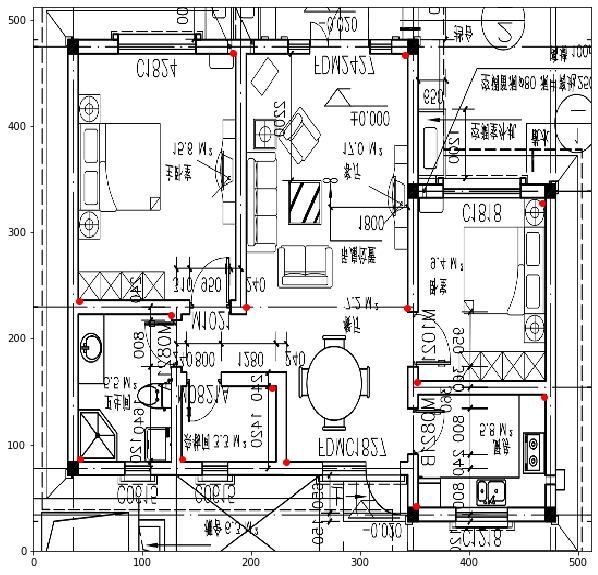

In [62]:
plt.figure(figsize = (10,10))
plt.pcolormesh(img, cmap ='gist_gray')
for room in v['points']:
    plt.plot(room[0], room[1],'ro')
    plt.plot(room[2], room[3],'ro')


json decode

In [66]:
def get_box_dicts(img_dir):
    json_file = os.path.join(img_dir, "data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
        filename = os.path.join(img_dir, v['img_name'])
#         print(filename)
        height, width = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["points"]
        objs = []
        for room in annos:
            xmin = room[0]
            xmax = room[2]
            ymin = room[1]
            ymax = room[3]
            

            obj = {
                "bbox": [ymin, xmin, ymax, xmax],
#                 "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [ymin, xmin, ymax, xmax],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [67]:
json_dict = get_box_dicts(f"./data_{rescale}")

In [68]:
json_dict

[{'file_name': './data_512\\0134b1-1_512.png',
  'image_id': 0,
  'height': 512,
  'width': 512,
  'annotations': [{'bbox': [86, 136, 153, 219],
    'segmentation': [86, 136, 153, 219],
    'category_id': 0},
   {'bbox': [86, 43, 222, 126],
    'segmentation': [86, 43, 222, 126],
    'category_id': 0},
   {'bbox': [235, 42, 469, 183],
    'segmentation': [235, 42, 469, 183],
    'category_id': 0},
   {'bbox': [159, 352, 328, 467],
    'segmentation': [159, 352, 328, 467],
    'category_id': 0},
   {'bbox': [230, 195, 467, 341],
    'segmentation': [230, 195, 467, 341],
    'category_id': 0},
   {'bbox': [84, 232, 229, 343],
    'segmentation': [84, 232, 229, 343],
    'category_id': 0},
   {'bbox': [42, 351, 145, 469],
    'segmentation': [42, 351, 145, 469],
    'category_id': 0}]},
 {'file_name': './data_512\\0134b11-1_512.png',
  'image_id': 1,
  'height': 512,
  'width': 512,
  'annotations': [{'bbox': [42, 43, 123, 177],
    'segmentation': [42, 43, 123, 177],
    'category_id': 0